In [ ]:
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()


    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)
    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
           continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir,rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

In [ ]:
# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_cc200'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset_asd'  # Path to local folder to download files to
desired_diagnosis = 'asd'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)
download_data_dir = 'preprocessed_dataset_tdc'  # Path to local folder to download files to
desired_diagnosis = 'tdc'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

Could not find preprocessed_dataset_asd, creating now...
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050004_rois_cc200.1D
0.245% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050005_rois_cc200.1D
0.490% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050006_rois_cc200.1D
0.735% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050007_rois_cc200.1D
0.980% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050008_rois_cc200.1D
1.225% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050009_rois_cc200.1D
1.471% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pitt_0050010_rois_cc200.1D
1.716% percent complete
Retrieving: preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/Pi

In [ ]:
!mkdir dataset
!mkdir dataset/1
!mkdir dataset/0
!mv preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_cc200/* dataset/1
!mv preprocessed_dataset_tdc/Outputs/cpac/filt_global/rois_cc200/* dataset/0
!rm -rf preprocessed_dataset_asd/ preprocessed_dataset_tdc/

In [ ]:
import os
import numpy as np

dataset_path='dataset/'

data=[]
labels=[]
for class_name in os.listdir(dataset_path):
  class_path=os.path.join(dataset_path,class_name)
  if os.path.isdir(class_path):
    for file_name in os.listdir(class_path):
      file_path=os.path.join(class_path,file_name)
      if 'NYU' in file_path or 'SDSU' in file_path :
        data_file = np.loadtxt(file_path, comments='#')
        #data_file = nib.load(file_path)
        #f_data=data_file.get_fdata()
        data.append(data_file)
        labels.append(int(class_name))
print(labels.count(1))
print(labels.count(0))
data_corr=np.array(data)
labels_corr=np.array(labels)

85
119


In [ ]:
!pip install nilearn
import numpy as np
from nilearn.connectome import ConnectivityMeasure,sym_matrix_to_vec

# Initialize ConnectivityMeasure object
conn_est = ConnectivityMeasure(kind='correlation',discard_diagonal=True) # Connectivity Estimator

# List to store connectivity matrices for each subject
conn_matrices = []

# Compute connectivity matrices for each subject
for data_point in data_corr:
    # Compute connectivity matrix for the current subject
    conn_matrix = conn_est.fit_transform([data_point])[0]

    # Append the computed connectivity matrix to the list
    conn_matrices.append(conn_matrix)

# Print the connectivity matrix of the first subject as an example
print(conn_matrices[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 22.5 MB/s eta 0:00:00
[[ 1.         -0.3542739   0.02800201 ...  0.10231879 -0.21389315
   0.37334383]
 [-0.3542739   1.          0.12749609 ... -0.25821202 -0.05221315
  -0.45902592]
 [ 0.02800201  0.12749609  1.         ...  0.12296357  0.00879844
  -0.14136649]
 ...
 [ 0.10231879 -0.25821202  0.12296357 ...  1.          0.06756249
   0.28411717]
 [-0.21389315 -0.05221315  0.00879844 ...  0.06756249  1.
  -0.14767488]
 [ 0.37334383 -0.45902592 -0.14136649 ...  0.28411717 -0.14767488
   1.        ]]


In [ ]:
corr_sum_asd = np.zeros_like(conn_matrices[0])  # Initialize with zeros
corr_sum_tdc = np.zeros_like(conn_matrices[0])  # Initialize with zeros
print(corr_sum_asd)
num_asd =0
num_tdc =0
#print(len(labels))
for i in range(len(labels)):
    if labels[i] == 1:
        num_asd+=1
        #print(i)
        corr_sum_asd += conn_matrices[i]  # Add the connectivity matrix to corr_sum_asd
    else:
        num_tdc+=1
        corr_sum_tdc += conn_matrices[i]  # Add the connectivity matrix to corr_sum_tdc

print(num_asd)

avg_corr_asd = corr_sum_asd / num_asd  # Compute average for ASD group
avg_corr_tdc = corr_sum_tdc / num_tdc  # Compute average for TDC group
print(avg_corr_asd)
diff_corr_matrix=np.subtract(avg_corr_tdc,avg_corr_asd)
arr=sym_matrix_to_vec(diff_corr_matrix,discard_diagonal=True)
enum_arr = list(enumerate(arr))

# Sort the array based on values
sorted_arr = sorted(enum_arr, key=lambda x: x[1])

# Get the indices and values of the largest and smallest 1000 elements
largest_indices = [idx for idx, val in sorted_arr[-1000:]]

smallest_indices = [idx for idx, val in sorted_arr[:1000]]

combined_indices=smallest_indices+largest_indices
sorted_indices=np.sort(combined_indices)
print(sorted_indices)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
85
[[ 1.         -0.10673409 -0.04957689 ... -0.0169658  -0.06892433
  -0.04940669]
 [-0.10673409  1.          0.1898399  ... -0.03786567 -0.05485093
  -0.0043911 ]
 [-0.04957689  0.1898399   1.         ... -0.02285931  0.08407262
  -0.06412908]
 ...
 [-0.0169658  -0.03786567 -0.02285931 ...  1.          0.0591537
   0.02751312]
 [-0.06892433 -0.05485093  0.08407262 ...  0.0591537   1.
  -0.0566303 ]
 [-0.04940669 -0.0043911  -0.06412908 ...  0.02751312 -0.0566303
   1.        ]]
[   34    48    54 ... 19855 19875 19878]


<Axes: >

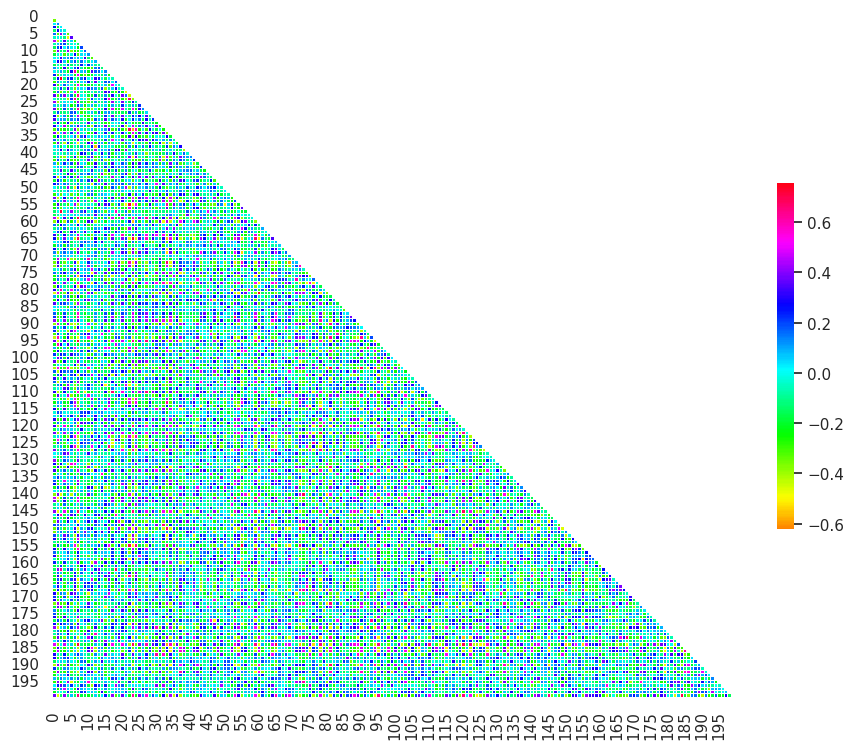

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = conn_matrices[0]
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='hsv', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
data=[]
for c_matrix in conn_matrices:
  data.append(sym_matrix_to_vec(c_matrix,discard_diagonal=True))
data=np.array(data)
labels=(np.array(labels))
print(data.shape)
print(labels.shape)

(204, 19900)
(204,)


In [ ]:
def extract_reduced_data(input):
  res=[]
  for i in sorted_indices:
    res.append(input[i])
  return res

data_reduced=[]
for data_seg in data:
  data_reduced.append(extract_reduced_data(data_seg))
data_reduced=np.array(data_reduced)
print(data_reduced.shape)

(204, 2000)


In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels=train_test_split(data_reduced,labels,test_size=0.2,random_state=42)
train_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
svm_model.fit(train_data, train_labels)
h
print("Accuracy:", accuracy)

Accuracy: 0.9024390243902439


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.85
Recall: 0.9444444444444444
F1-score: 0.8947368421052632


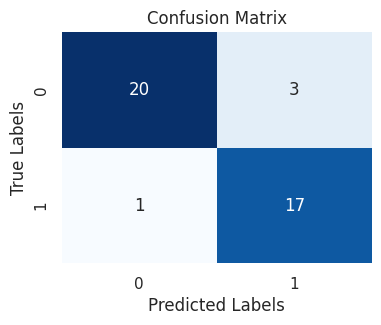

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm

conf_matrix = confusion_matrix(test_labels, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()